In [1]:
import pandas as pd
import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
def format_large_numbers(x, pos):
    if np.abs(x) >= 1e9:
        return f'{x * 1e-9:.1f}B'  # Format as Billion
    elif np.abs(x) >= 1e6:
        return f'{x * 1e-6:.1f}M'  # Format as Million
    elif np.abs(x) >= 1e3:
        return f'{x * 1e-3:.1f}K'  # Format as Thousand
    else:
        return f'{x:.0f}'  # Less than 1,000

In [3]:
tvl_data = ['data/algorand.csv', 'data/aptos.csv', 'data/cardano.csv', 'data/icp.csv', 
            'data/near.csv', 'data/solana.csv', 'data/sui.csv', 'data/tezos.csv']

price_data = ['price/algo_usd.csv', 'price/apt_usd.csv', 'price/ada_usd.csv', 'price/icp_usd.csv',
              'price/near_usd.csv', 'price/sol_usd.csv', 'price/sui_usd.csv', 'price/xtz_usd.csv']

stables_data = ['algorand.csv', 'aptos.csv', 'cardano.csv', 'icp.csv', 
                'near.csv', 'solana.csv', 'sui.csv', 'tezos.csv']


staking_data = ['algorand.json', 'aptos.json', 'cardano.json', 'icp.json',
                'near.json', 'solana.json', 'sui.json',  'tezos.json']

chain_names = ['Algorand', 'Aptos', 'Cardano', 'ICP', 
               'NEAR', 'Solana', 'Sui', 'Tezos']

In [13]:
def get_tvl(chain : str , tvl_file : str):
    """
    Input: string and csv
    Output: dataframe with the defined format
    """
    df = pd.read_csv(tvl_file)

    protocol_name = df.columns[0]
    tvl_column = 'Total'

    #Transpose dates into rows 
    df_melted = df.melt(id_vars=[protocol_name], var_name='Date', value_name=chain)
    
    # Get the total TVL values
    df_melted = df_melted[df_melted[protocol_name]==tvl_column]

    df_melted['Date'] = pd.to_datetime(df_melted['Date'], format="%d/%m/%Y")
    df_melted = df_melted[df_melted['Date'] >= '12/05/2022']

    df_melted.reset_index(inplace=True, drop=True)
    df_melted = df_melted[['Date', chain]]

    return df_melted



In [14]:
def get_price(price_file: str):
    """
    Input: csv file with price feed from Coingecko
    Output: processed price df
    """
    price_df = pd.read_csv(price_file)
    price_df['snapped_at'] = pd.to_datetime(price_df['snapped_at'])
    price_df['snapped_at'] = price_df['snapped_at'].dt.strftime('%Y-%m-%d')
    price_df['snapped_at'] = pd.to_datetime(price_df['snapped_at'])
    return price_df

def get_stables_mcap(stablecoin_file: str):
    """ 
    Input: csv file with Stablecoins mcap from Defillama
    Output: processed df
    """
    stables = pd.read_csv(f'stablecoins/{stablecoin_file}')
    stables['Date'] = pd.to_datetime(stables['Date'])
    stables.rename(columns={'Total': 'StablesMCap'}, inplace=True)
    return stables[['Date', 'StablesMCap']]

def get_staking_rewards(staking_file : str):
    """ 
    Input: json file with staking metrics
    Output: Clean df with staking metrics
    """
    file_path = f'staking/{staking_file}'
    with open(file_path, 'r') as f:
        json_data = json.load(f)
    
    metrics = json_data['data']['assets'][0]['metrics']
    df = pd.DataFrame(metrics)
    df['createdAt'] = df['createdAt'].str[:10]
    df.rename(columns={'defaultValue': 'StakingRewards'}, inplace=True)
    df['createdAt'] = pd.to_datetime(df['createdAt'])
    return df

def merge_df(tvl_df : pd.DataFrame , price_df : pd.DataFrame, 
             stable_df: pd.DataFrame, staking_df: pd.DataFrame):
    """ 
    Input: 2 dataframes to merge
    Output: merged df with all info
    """

    merged_df = tvl_df.merge(price_df, left_on='Date', right_on='snapped_at', how='left')
    merged_df = merged_df.merge(stable_df, left_on='Date', right_on='Date', how='left')
    merged_df = merged_df.merge(staking_df, left_on='Date', right_on='createdAt', how='left')
    merged_df['Liquidity'] = merged_df['total_volume']/merged_df['market_cap'] * 100
    merged_df.drop(['snapped_at', 'createdAt', 'metricKey'], axis=1, inplace=True)
    return merged_df

In [15]:
interest_rates = pd.read_csv('inlfation/interest_rates.csv',header=None)
interest_rates.drop(0, axis=1, inplace=True)
interest_rates.columns = ['Date', 'InterestRate']
interest_rates['Date'] = pd.to_datetime(interest_rates['Date'])

In [16]:
datasets = {}

for token in chain_names:
    file_idx = chain_names.index(token)
    tvl = get_tvl(token, tvl_data[file_idx])
    price = get_price(price_data[file_idx])
    stable = get_stables_mcap(stables_data[file_idx])
    staking = get_staking_rewards(staking_data[file_idx])
    final_df = merge_df(tvl, price, stable, staking)
    final_df = final_df.merge(interest_rates, left_on='Date', right_on='Date', how='left')
    datasets[token] = final_df

    print(f"*** Data Characteristics for {token} ***\n")
    print(final_df.describe())

*** Data Characteristics for Algorand ***

                                Date      Algorand       price    market_cap  \
count                            676  6.760000e+02  676.000000  6.760000e+02   
mean   2023-10-12 13:52:53.964496896  1.650660e+08    0.170678  1.312558e+09   
min              2022-12-05 00:00:00  4.587640e+07    0.088466  6.928687e+08   
25%              2023-04-25 18:00:00  1.276157e+08    0.124736  9.921668e+08   
50%              2023-10-11 12:00:00  1.588979e+08    0.169934  1.296154e+09   
75%              2024-03-28 06:00:00  1.944939e+08    0.210657  1.581093e+09   
max              2024-09-13 00:00:00  4.268436e+08    0.318622  2.569773e+09   
std                              NaN  5.396096e+07    0.051891  3.852701e+08   

       total_volume   StablesMCap  StakingRewards   Liquidity  InterestRate  
count  6.760000e+02  6.760000e+02      676.000000  676.000000    676.000000  
mean   6.341820e+07  1.499500e+08        6.222613    4.674972      5.071109  
mi

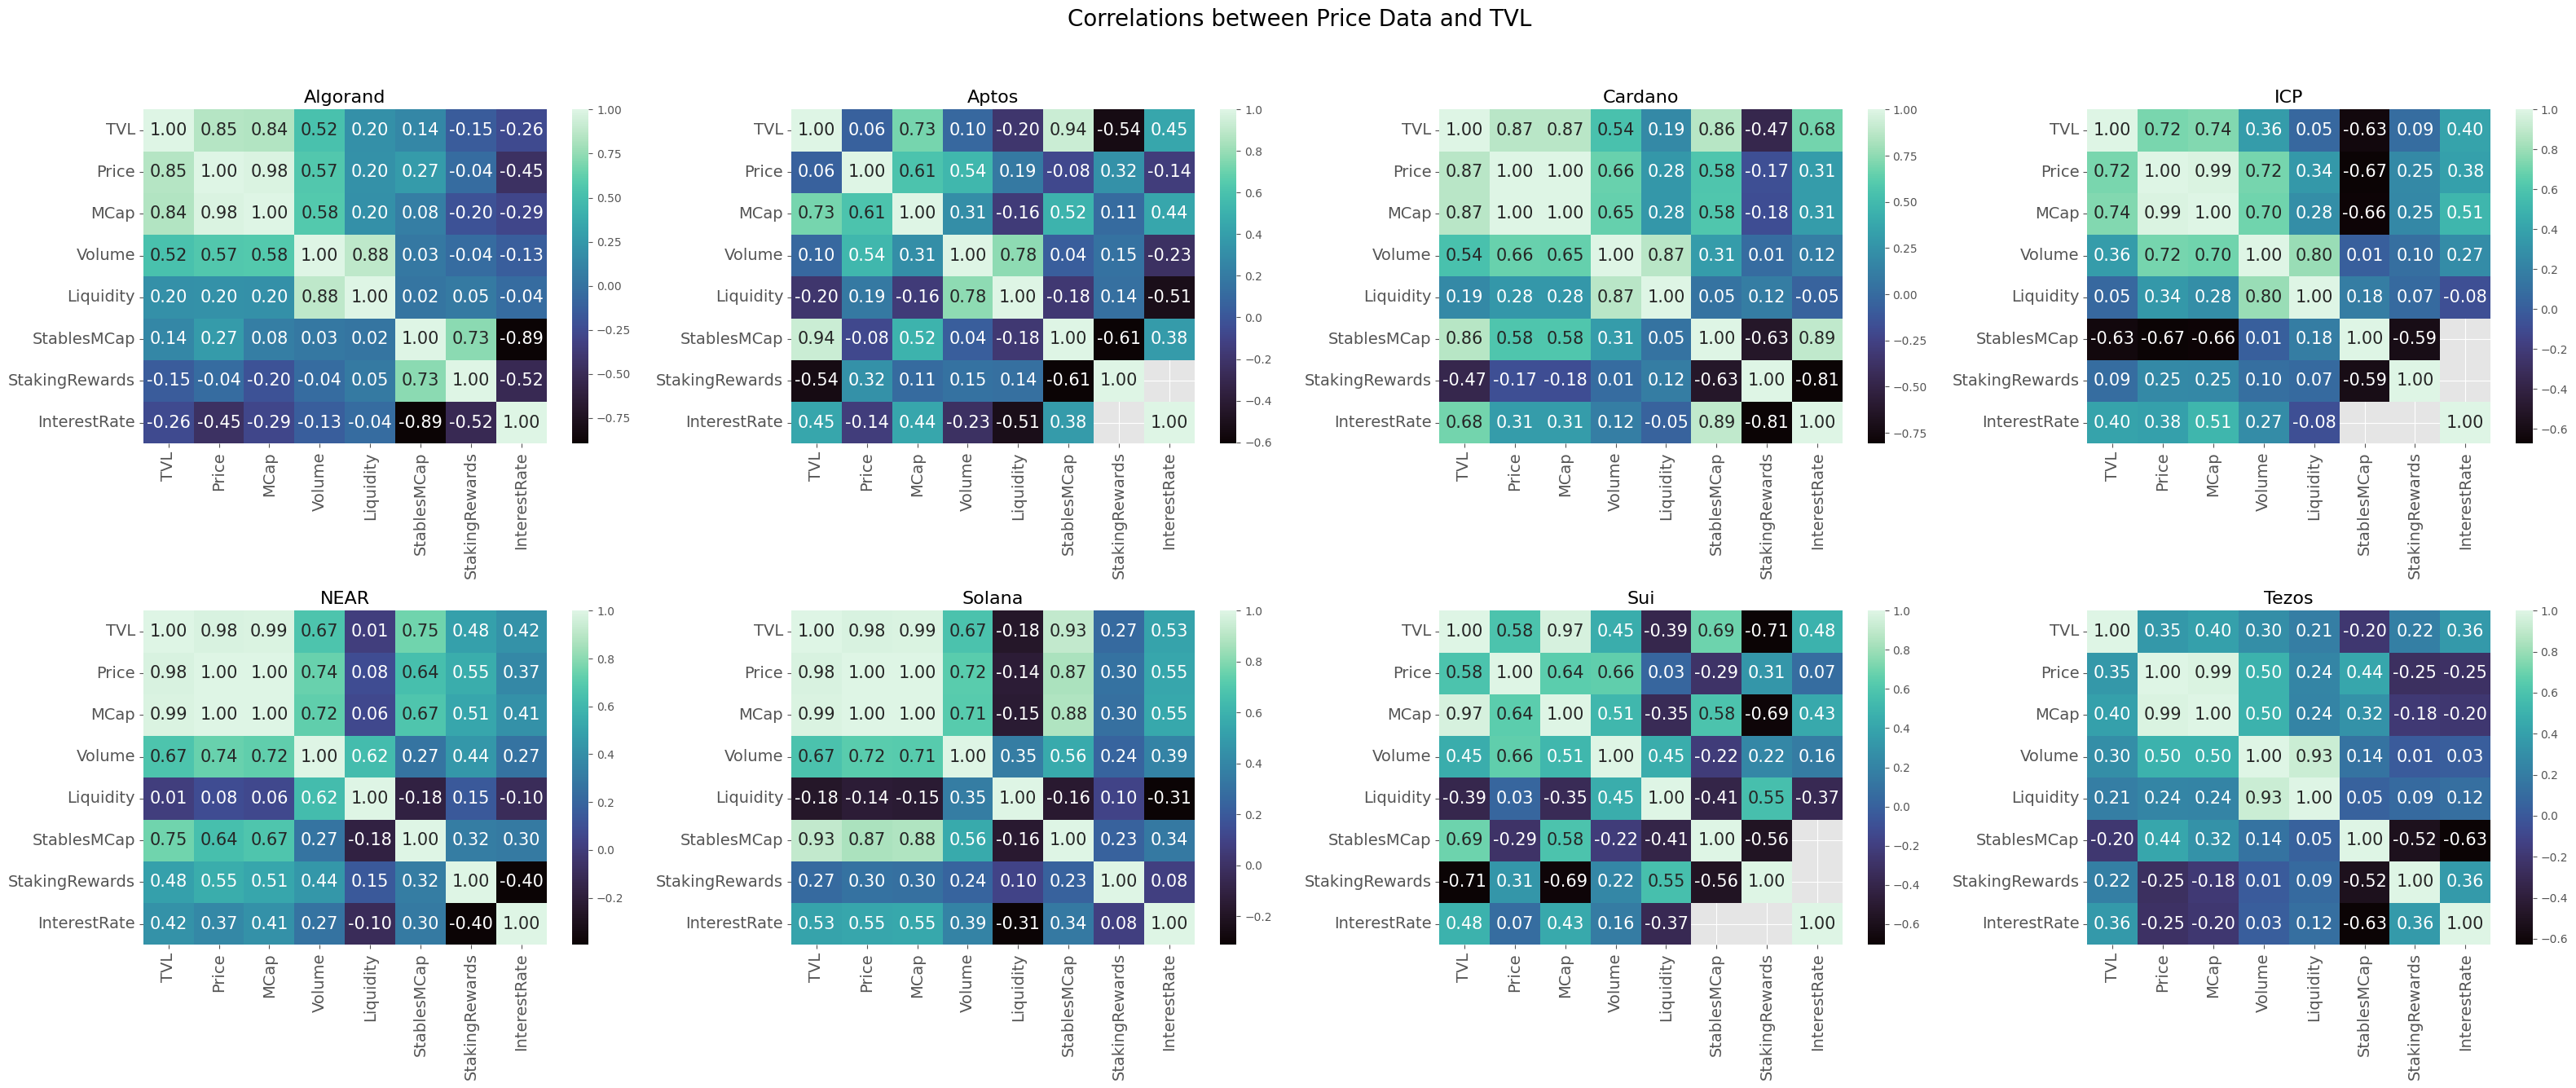

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(32, 14))  # Slightly larger size for better readability

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each token and plot its heatmap
for i, token in enumerate(chain_names):
    # Get the dataset for the current token
    df = datasets[token]
    df.rename(columns={token: 'TVL', 'price': 'Price', 
                       'market_cap': 'MCap', 'total_volume': 'Volume'}, inplace=True)
    
    # Compute the correlation matrix between TVL and price
    corr_matrix = df[['TVL', 'Price', 'MCap', 'Volume',
                      'Liquidity', 'StablesMCap', 'StakingRewards', 'InterestRate']].corr()
    
    # Plot the heatmap in the corresponding subplot
    sns.heatmap(corr_matrix, annot=True, cmap='mako', ax=axes[i], annot_kws={"size": 15}, fmt='.2f')

    # Set the title for each subplot
    axes[i].set_title(token, fontsize=16)  # Increase the title size

    # Increase the size of the x and y tick labels
    axes[i].tick_params(axis='x', labelsize=14)
    axes[i].tick_params(axis='y', labelsize=14)

fig.suptitle('Correlations between Price Data and TVL', fontsize=20)  # Increase the main title size
# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Add some margin for the suptitle
plt.show()

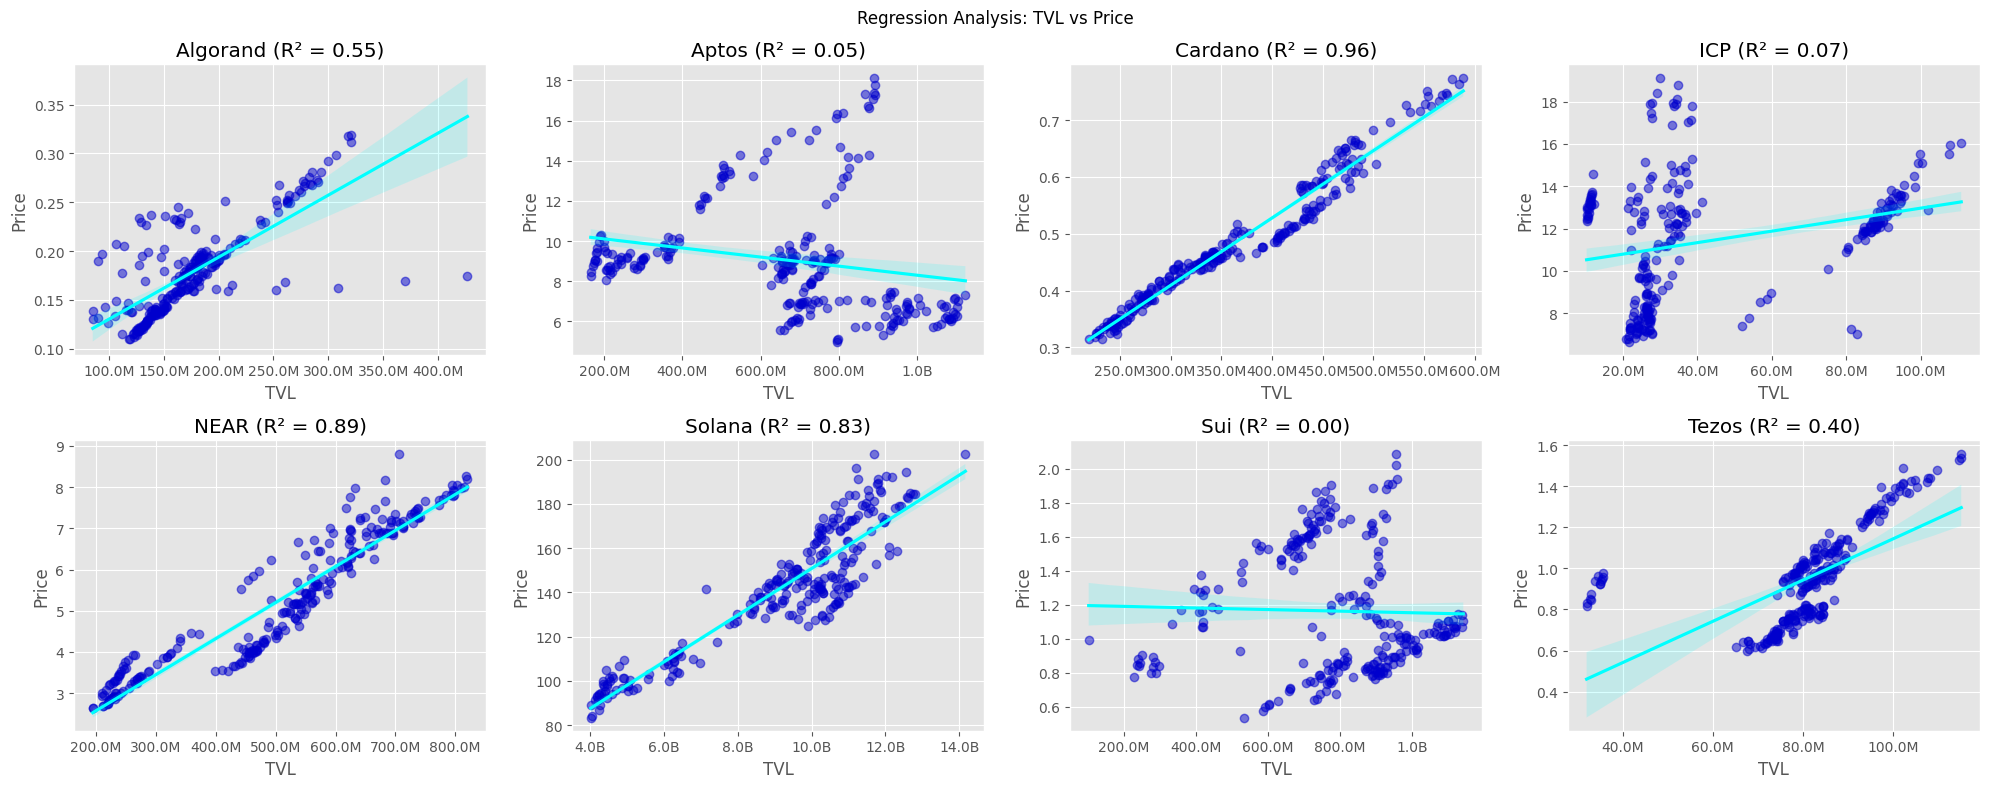

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each token and plot its scatter plot
for i, token in enumerate(chain_names):
    # Get the dataset for the current token
    df = datasets[token]
    df.rename(columns={token: 'TVL', 'price': 'Price', 
                       'market_cap': 'MCap', 'total_volume': 'Volume'}, inplace=True)
    

    # Extract TVL and Price for the linear regression
    X = df[['TVL']].values  # TVL should be 2D for sklearn
    y = df['Price'].values
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict values and compute R^2
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    # Plot the scatter plot with regression line using seaborn
    sns.regplot(x='TVL', y='Price', data=df, ax=axes[i], scatter_kws={'alpha':0.5, 'color': 'mediumblue'}, line_kws={'color':'cyan'})
    
    
    # Plot TVL vs Price (or vice versa)
    #axes[i].scatter(df['Price'], df['TVL'], alpha=0.5, color='mediumblue')
    
    # Set the title and labels
    axes[i].set_title(f'{token} (R² = {r2:.2f})')
    axes[i].set_xlabel('TVL')
    axes[i].set_ylabel('Price')

    # Set custom formatter for both axes to display in 'K', 'M', 'B' format
    #axes[i].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
    axes[i].xaxis.set_major_formatter(FuncFormatter(format_large_numbers))

fig.suptitle('Regression Analysis: TVL vs Price')
# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()

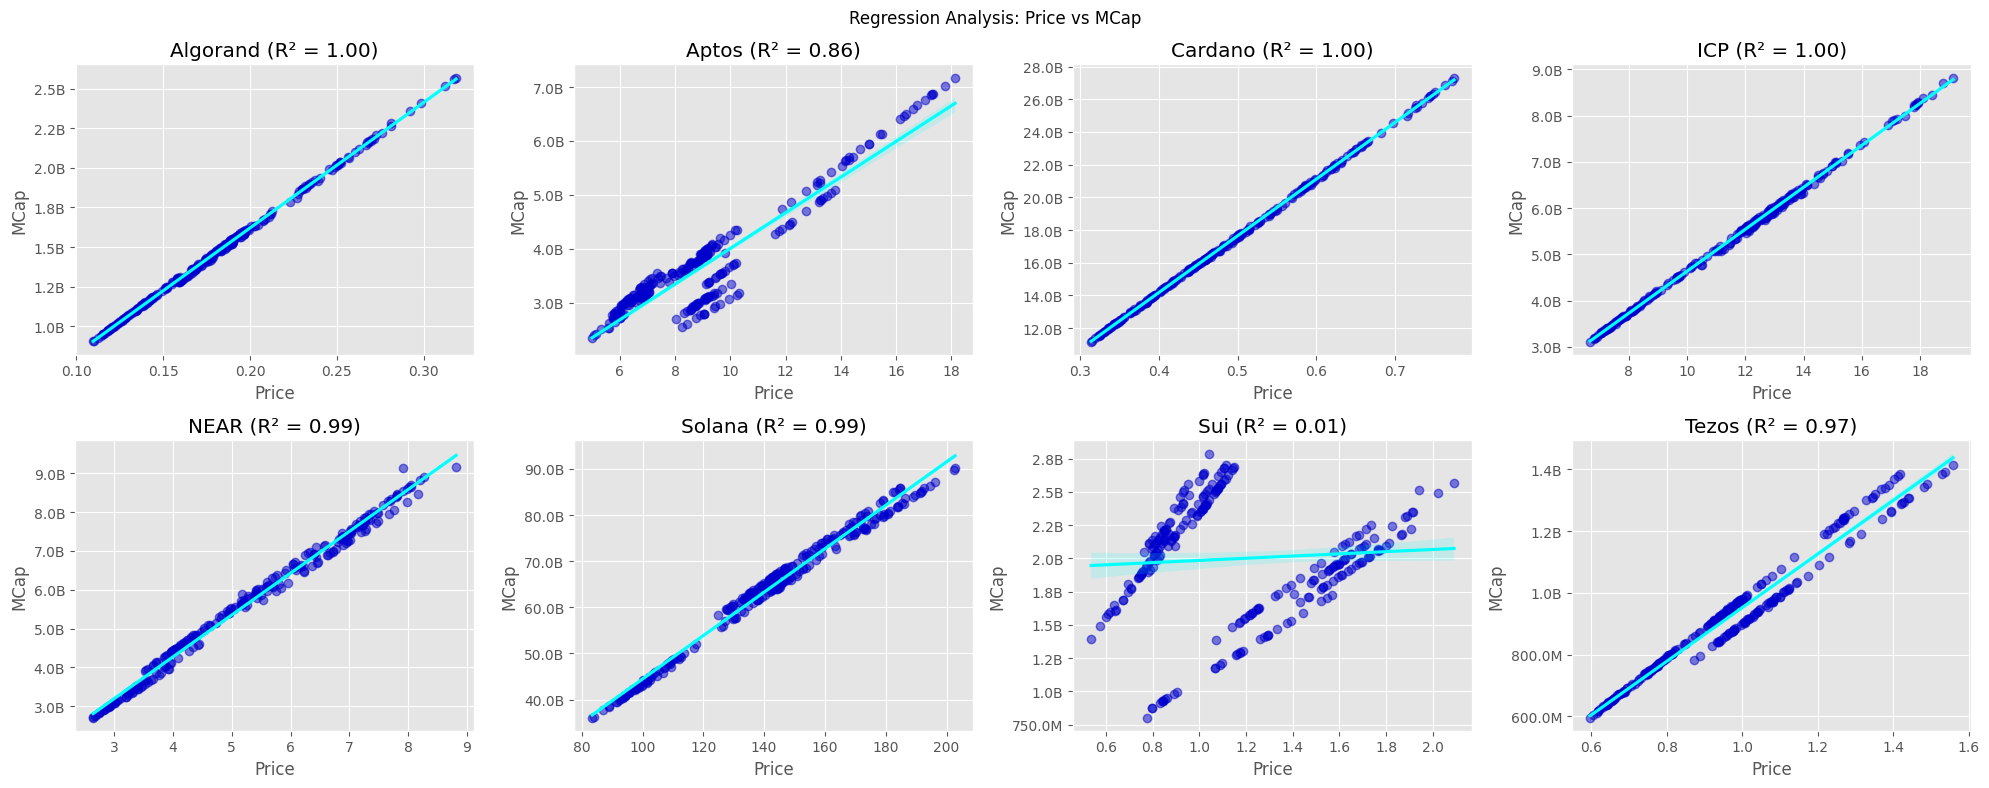

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each token and plot its scatter plot
for i, token in enumerate(chain_names):
    # Get the dataset for the current token
    df = datasets[token]
    df.rename(columns={token: 'TVL', 'price': 'Price', 
                       'market_cap': 'MCap', 'total_volume': 'Volume'}, inplace=True)
    

    # Extract TVL and Price for the linear regression
    X = df[['Price']].values  # TVL should be 2D for sklearn
    y = df['MCap'].values
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict values and compute R^2
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    # Plot the scatter plot with regression line using seaborn
    sns.regplot(x='Price', y='MCap', data=df, ax=axes[i], scatter_kws={'alpha':0.5, 'color': 'mediumblue'}, line_kws={'color':'cyan'})
    
    
    # Plot TVL vs Price (or vice versa)
    #axes[i].scatter(df['Price'], df['TVL'], alpha=0.5, color='mediumblue')
    
    # Set the title and labels
    axes[i].set_title(f'{token} (R² = {r2:.2f})')
    axes[i].set_xlabel('Price')
    axes[i].set_ylabel('MCap')

    # Set custom formatter for both axes to display in 'K', 'M', 'B' format
    axes[i].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
    #axes[i].xaxis.set_major_formatter(FuncFormatter(format_large_numbers))

fig.suptitle('Regression Analysis: Price vs MCap')
# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()

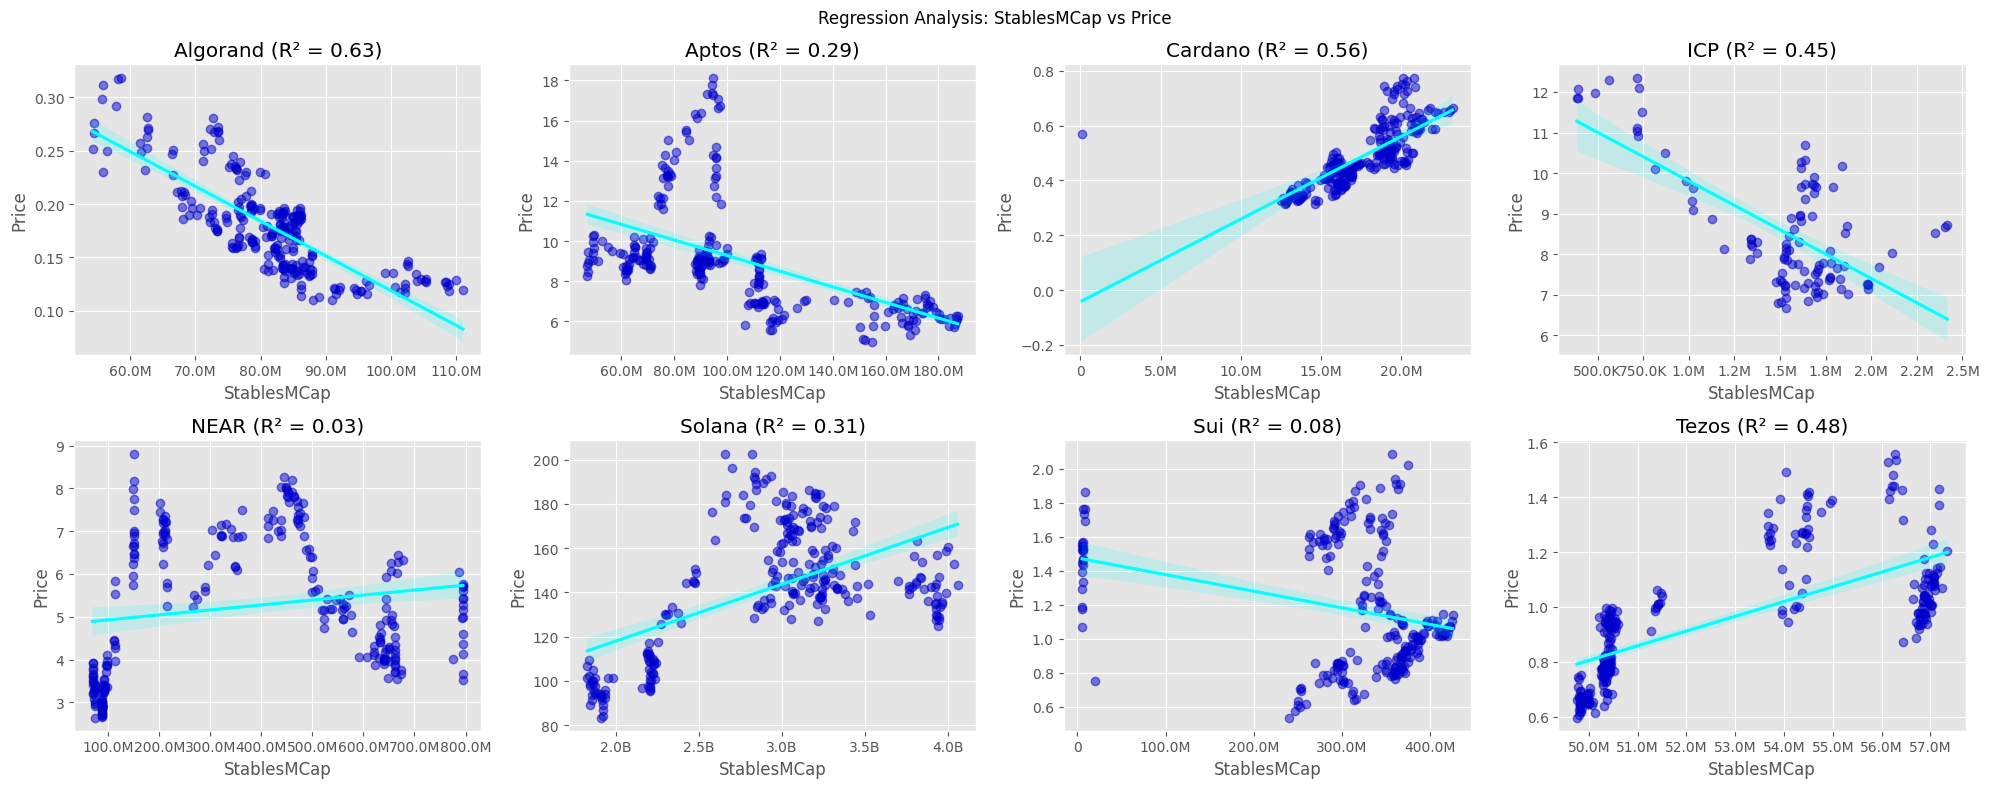

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each token and plot its scatter plot
for i, token in enumerate(chain_names):
    # Get the dataset for the current token
    df = datasets[token]
    df.rename(columns={token: 'TVL', 'price': 'Price', 
                       'market_cap': 'MCap', 'total_volume': 'Volume'}, inplace=True)
    
    df = df[df['StablesMCap'].notna()]
    # Extract TVL and Price for the linear regression
    X = df[['StablesMCap']].values  # TVL should be 2D for sklearn
    y = df['Price'].values
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict values and compute R^2
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    # Plot the scatter plot with regression line using seaborn
    sns.regplot(x='StablesMCap', y='Price', data=df, ax=axes[i], scatter_kws={'alpha':0.5, 'color': 'mediumblue'}, line_kws={'color':'cyan'})
    
    
    # Plot TVL vs Price (or vice versa)
    #axes[i].scatter(df['Price'], df['TVL'], alpha=0.5, color='mediumblue')
    
    # Set the title and labels
    axes[i].set_title(f'{token} (R² = {r2:.2f})')
    axes[i].set_xlabel('StablesMCap')
    axes[i].set_ylabel('Price')

    # Set custom formatter for both axes to display in 'K', 'M', 'B' format
    #axes[i].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
    axes[i].xaxis.set_major_formatter(FuncFormatter(format_large_numbers))

fig.suptitle('Regression Analysis: StablesMCap vs Price')
# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()

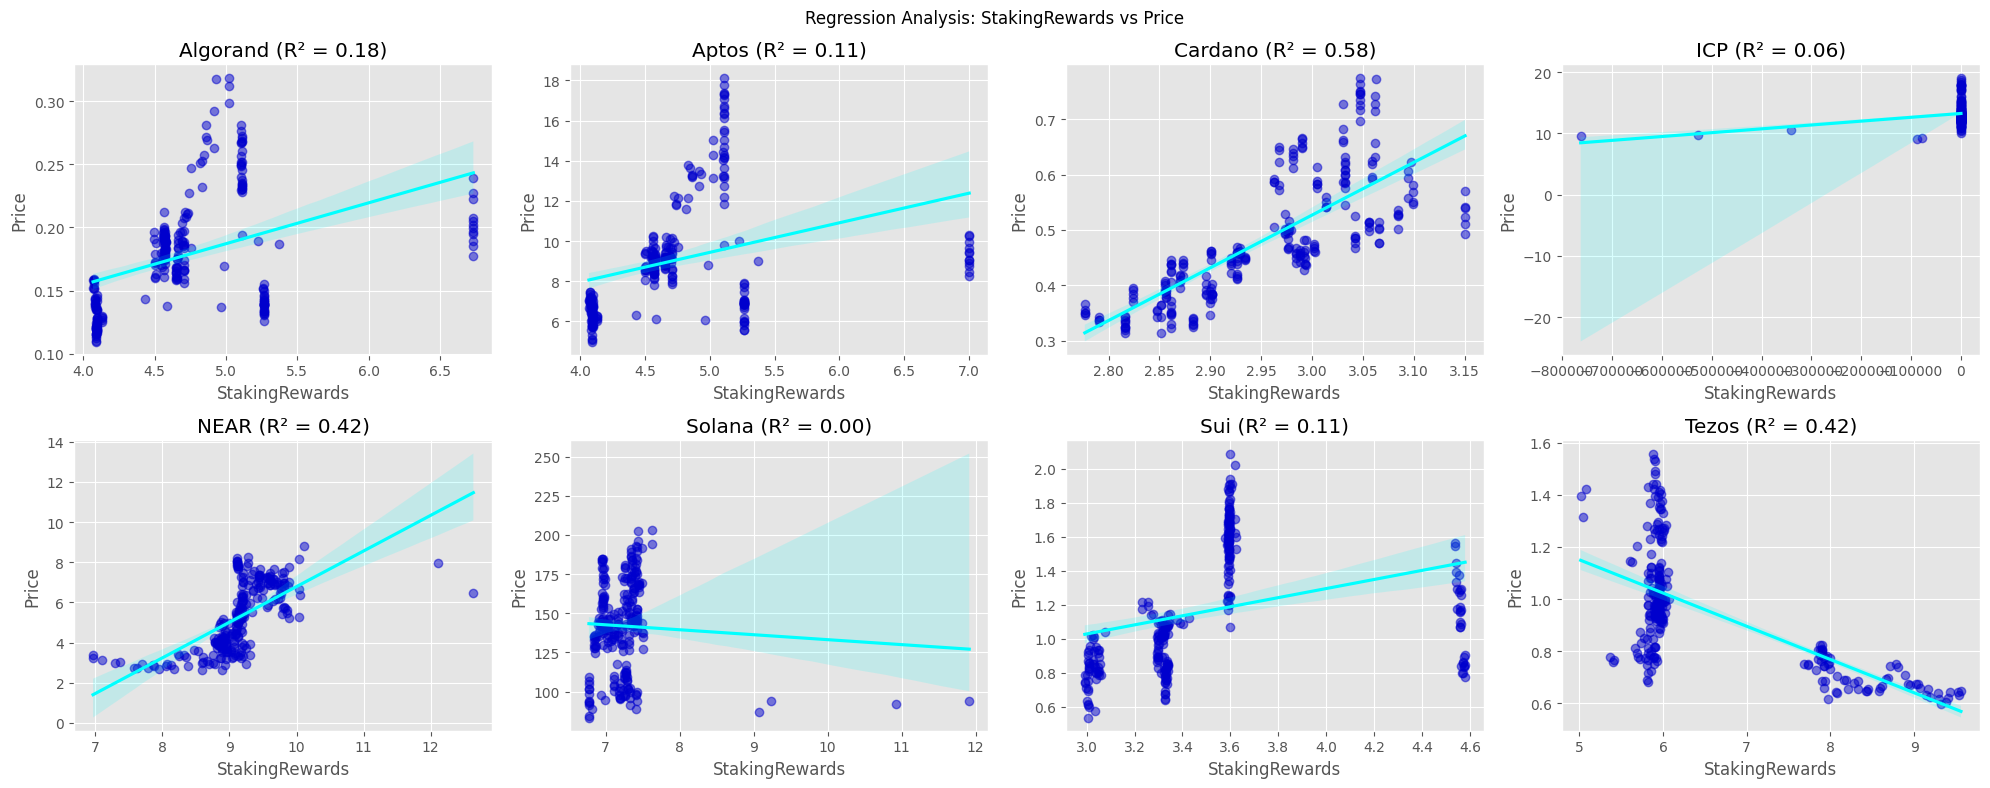

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each token and plot its scatter plot
for i, token in enumerate(chain_names):
    # Get the dataset for the current token
    df = datasets[token]
    df.rename(columns={token: 'TVL', 'price': 'Price', 
                       'market_cap': 'MCap', 'total_volume': 'Volume'}, inplace=True)
    
    df = df[df['StakingRewards'].notna()]
    # Extract TVL and Price for the linear regression
    X = df[['StakingRewards']].values  # TVL should be 2D for sklearn
    y = df['Price'].values
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict values and compute R^2
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    # Plot the scatter plot with regression line using seaborn
    sns.regplot(x='StakingRewards', y='Price', data=df, ax=axes[i], scatter_kws={'alpha':0.5, 'color': 'mediumblue'}, line_kws={'color':'cyan'})
    
    
    # Plot TVL vs Price (or vice versa)
    #axes[i].scatter(df['Price'], df['TVL'], alpha=0.5, color='mediumblue')
    
    # Set the title and labels
    axes[i].set_title(f'{token} (R² = {r2:.2f})')
    axes[i].set_xlabel('StakingRewards')
    axes[i].set_ylabel('Price')

    # Set custom formatter for both axes to display in 'K', 'M', 'B' format
    #axes[i].yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
    #axes[i].xaxis.set_major_formatter(FuncFormatter(format_large_numbers))

fig.suptitle('Regression Analysis: StakingRewards vs Price')
# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()